In [74]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import collections
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.spatial import distance

# k-means
from sklearn.cluster import KMeans

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

In [75]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def image_bin_adaptive(image_gs):
    image_bin = cv2.adaptiveThreshold(image_gs, 120, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

In [76]:
def select_roi(image_orig, image_bin):
    '''Oznaciti regione od interesa na originalnoj slici. (ROI = regions of interest)
        Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
        Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
        Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni
        i niz slika koje predstavljaju regione sortirane po rastućoj vrednosti x ose
    '''
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    regions = []
    props = []
    sizes = []
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour)
        region = image_bin[y:y+h+1,x:x+w+1];
        props.append((x, w*h, resize_region(region)))
        cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
        cv2.drawContours(image_orig, contours, -1, (255,0,0), 1) 
    props = sorted(props)
    
    #print [(y,x) for y,x,w,h,region in props]
    sizes = [size for x,size,region in props] #vraca povrsinu konture
    regions = [region for x,size,region in props] #vraca region koji obuhvata kontura
    
    return image_orig, regions, sizes

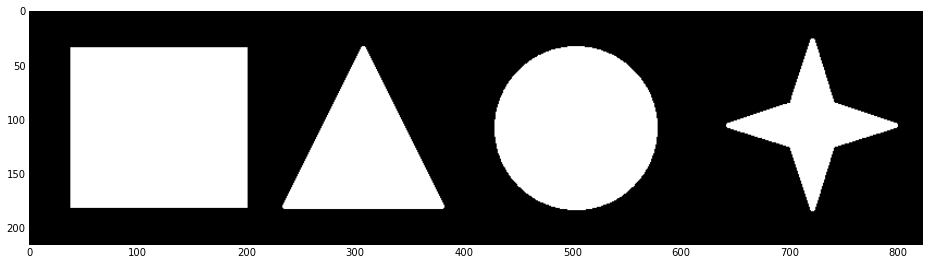

In [77]:
img = load_image('primer1_train.jpg')
img_inv = invert(erode(dilate(image_bin(image_gray(img)))))
display_image(img_inv)

4


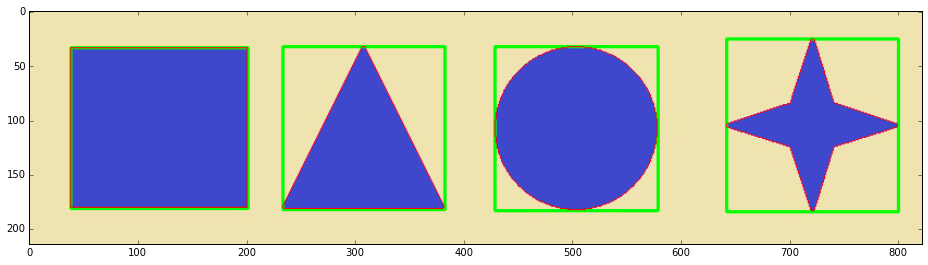

In [78]:
selected_reg,geometry,distances=select_roi(img.copy(), img_inv)
display_image(selected_reg)
print len(geometry)

In [79]:
def create_ann(output):
    '''
    Implementirati veštačku neuronsku mrežu sa 28x28 ulaznih neurona i jednim skrivenim slojem od 128 neurona.
    Odrediti broj izlaznih neurona. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    # Postaviti slojeve neurona mreže 'ann'
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(output, activation='sigmoid'))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

In [80]:
alfabet = ['quadric','triangle', 'circle' ,'star']
distances = np.array(distances).reshape(len(distances), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(distances)
inputs = prepare_for_ann(geometry)
outputs = convert_output(alfabet)
ann = create_ann(len(alfabet))
ann = train_ann(ann, inputs, outputs)

In [81]:
def display_result(outputs, alphabet, k_means):
    '''
    Funkcija određuje koja od grupa predstavlja razmak između reči, a koja između slova, i na osnovu
    toga formira string od elemenata pronađenih sa slike.
    Args:
        outputs: niz izlaza iz neuronske mreže.
        alphabet: niz karaktera koje je potrebno prepoznati
        kmeans: obučen kmeans objekat
    Return:
        Vraća formatiran string
    '''
    big_elements = {}
    small_elements = {}
    big_group = max(enumerate(k_means.cluster_centers_), key = lambda x: x[1])[0] #index neurona koji je najvise pobudjen
    for idx, output in enumerate(outputs[0:,:]):
        elem = alphabet[winner(output)]
        if (k_means.labels_[idx] == big_group):
            if elem not in big_elements:
                big_elements[elem] = 0
            big_elements[elem] += 1
        else:
            if elem not in small_elements:
                small_elements[elem] = 0
            small_elements[elem]  += 1
    result = ""
    for key, value in big_elements.iteritems():
        result += str(value) + " big " + str(key) + ("s\n" if (value > 1 and value != 0) else "\n")
    for key, value in small_elements.iteritems():
        result += str(value) + " small " + str(key) + ("s\n" if (value > 1 and value != 0) else "\n")
    return result
    

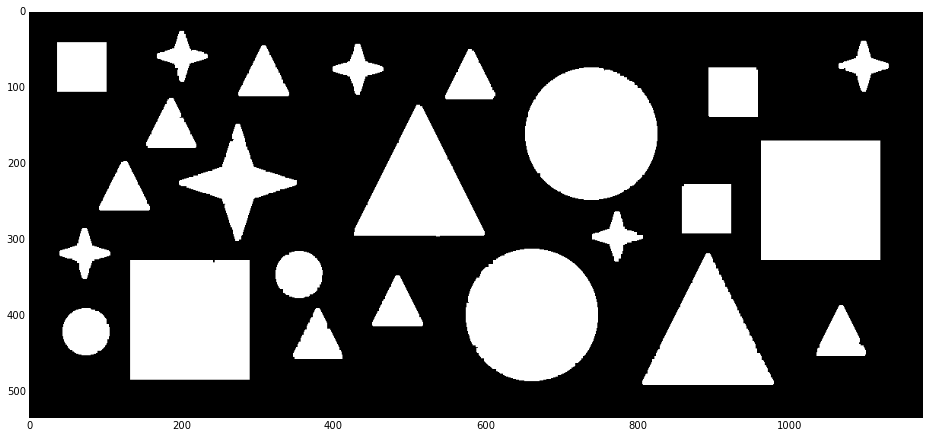

In [82]:
img_test = load_image('primer1_test.jpg')
img_inv_test = invert(erode(erode(dilate(image_bin(image_gray(img_test))))))
display_image(img_inv_test)

4


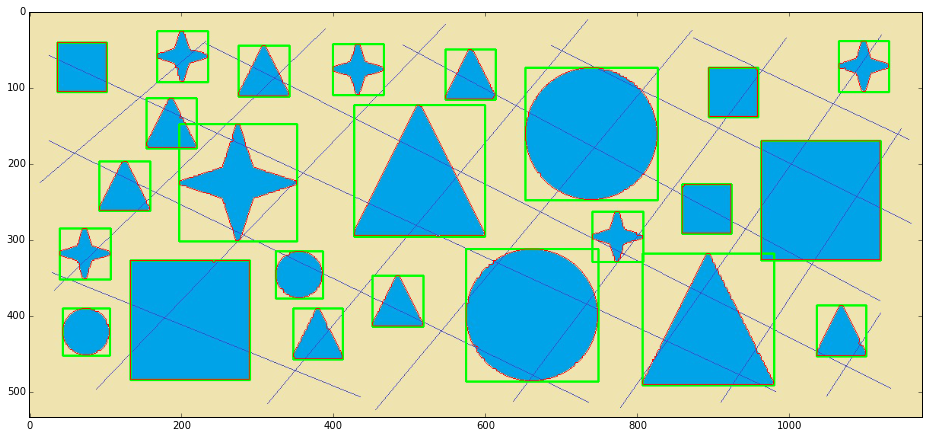

In [85]:
selected_reg,geometry_test,region_distances_test=select_roi(img_test.copy(), img_inv_test)
display_image(selected_reg)
print len(geometry_test)

In [86]:
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)
inputs_test = prepare_for_ann(geometry_test)
results_test = ann.predict(np.array(inputs_test, np.float32))
print display_result(results_test, alfabet, k_means_test)

2 big triangles
2 big circles
1 big star
2 big quadrics
7 small triangles
2 small circles
5 small stars
3 small quadrics

